---
__Universidad Tecnológica Nacional, Buenos Aires__\
__Ingeniería Industrial__\
__Investigación Operativa I4051__\
__Autor: Rodrigo Maranzana__, Rmaranzana@frba.utn.edu.ar

---

# Generador de Lyrics con Cadenas de Markov

En este Notebook, buscamos imitar con un modelo de Markov la generación automática de texto.

Esto implica leer una canción existente y entender el salto entre sus palabras, con una probabilidad de transición asociada.

Las secuencias aleatorias de palabras se generan mediante una Cadena de Markov, por lo tanto, la palabra siguiente solamente depende de la palabra anterior.

El objetivo final, es obtener un random walk que represente nuevas letras de canciones existentes.

In [1]:
import numpy as np
import networkx as nx
import copy
import matplotlib.pyplot as plt
import re

## Input de datos

Copiamos los lyrics de una canción y la cargamos como variable string. Una canción que funciona muy bien con este modelo es Harder, Better, Faster, Stronger de Daft Punk; porque genera un grafo bien conectado.

De ahora en más, a esta variable con la letra la llamaremos Corpus.

In [2]:
orig_corpus = """Work it
Make it
Do it
Makes us
Harder
Better
Faster
Stronger
More than
Hour
Hour
Never
Ever
After
Work is
Over
Work it
Make it
Do it
Makes us
Harder
Better
Faster
Stronger
Work it harder, make it better
Do it faster, makes us stronger
More than ever, hour after hour
Work is never over
Work it harder, make it better
Do it faster, makes us stronger
More than ever, hour after hour
Work is never over
Work it harder, make it better
Do it faster, makes us stronger
More than ever, hour after hour
Work is never over
Work it harder, make it better
Do it faster, makes us stronger
More than ever, hour after hour
Work is never over
Work it harder, make it better
Do it faster, makes us stronger
More than ever, hour after hour
Work is never over
Work it harder, make it better
Do it faster, makes us
More than ever hour after hour
Work is never over
Work it harder, make it better
Do it faster, makes us stronger
More than ever, hour after hour
Work is never over
Work it harder, make it
Do it faster, makes us
More than ever, hour after hour
Work is never over
Work it harder, make it better
Do it faster, makes us strong
More than ever, hour after hour
Work is never over
Work it, make it better
Do it faster makes us stronger
More than ever, hour after hour
Work is never over
Work it, make it better
Do it faster makes us stronger
More than ever, hour after hour
Work is never over
Work it, make it better
Do it faster makes us stronger
More than ever, hour after hour
Work is never over
Work it harder
Do it faster
More than ever, hour
Work is never over
Work it harder, make it better
Do it faster makes us stronger
More than ever hour after hour
Work is never over
"""

## Limpieza y detección de palabras

Limpiamos la letra:
- Reemplazamos caracteres de fin de oración "\n" por "eol" (end of line)
- Eliminamos signos de puntuación.
- Convertimos todo a minúscula.

In [3]:
# Eliminamos end of line.
corpus = orig_corpus.replace('\n', ' eol ')

# Eliminamos signos de puntuación.
corpus = re.sub(r'[^\w]', ' ', corpus)

# Todo en minúscula.
corpus = corpus.lower()

print(corpus)

work it eol make it eol do it eol makes us eol harder eol better eol faster eol stronger eol more than eol hour eol hour eol never eol ever eol after eol work is eol over eol work it eol make it eol do it eol makes us eol harder eol better eol faster eol stronger eol work it harder  make it better eol do it faster  makes us stronger eol more than ever  hour after hour eol work is never over eol work it harder  make it better eol do it faster  makes us stronger eol more than ever  hour after hour eol work is never over eol work it harder  make it better eol do it faster  makes us stronger eol more than ever  hour after hour eol work is never over eol work it harder  make it better eol do it faster  makes us stronger eol more than ever  hour after hour eol work is never over eol work it harder  make it better eol do it faster  makes us stronger eol more than ever  hour after hour eol work is never over eol work it harder  make it better eol do it faster  makes us eol more than ever hour 

Individualizamos todas las palabras en una lista de python.

In [4]:
words = corpus.split(sep=" ")
words = [i for i in words if i != '']
words = np.array(words)

print(words)

['work' 'it' 'eol' 'make' 'it' 'eol' 'do' 'it' 'eol' 'makes' 'us' 'eol'
 'harder' 'eol' 'better' 'eol' 'faster' 'eol' 'stronger' 'eol' 'more'
 'than' 'eol' 'hour' 'eol' 'hour' 'eol' 'never' 'eol' 'ever' 'eol' 'after'
 'eol' 'work' 'is' 'eol' 'over' 'eol' 'work' 'it' 'eol' 'make' 'it' 'eol'
 'do' 'it' 'eol' 'makes' 'us' 'eol' 'harder' 'eol' 'better' 'eol' 'faster'
 'eol' 'stronger' 'eol' 'work' 'it' 'harder' 'make' 'it' 'better' 'eol'
 'do' 'it' 'faster' 'makes' 'us' 'stronger' 'eol' 'more' 'than' 'ever'
 'hour' 'after' 'hour' 'eol' 'work' 'is' 'never' 'over' 'eol' 'work' 'it'
 'harder' 'make' 'it' 'better' 'eol' 'do' 'it' 'faster' 'makes' 'us'
 'stronger' 'eol' 'more' 'than' 'ever' 'hour' 'after' 'hour' 'eol' 'work'
 'is' 'never' 'over' 'eol' 'work' 'it' 'harder' 'make' 'it' 'better' 'eol'
 'do' 'it' 'faster' 'makes' 'us' 'stronger' 'eol' 'more' 'than' 'ever'
 'hour' 'after' 'hour' 'eol' 'work' 'is' 'never' 'over' 'eol' 'work' 'it'
 'harder' 'make' 'it' 'better' 'eol' 'do' 'it' 'faster

## Modelado de Cadenas de Markov
### Diccionarios de transicion

En procesamiento de lenguaje natural, existen muchos estados (palabras) no comunicantes. Esto genera matrices de transición dispersas (sparse) con muchos valores nulos.

Una forma más eficiente, es crear un Diccionario de Transición, en lugar de una matriz. Es decir, guardamos los estados iniciales como claves de un diccionario, y solamente los estados finales que tengan probabilidad mayor a 0. Cabe resaltar, que se sigue cumpliendo la propiedad de la matriz de transición, en donde las filas suman 1.

Para crear el diccionario de transición con probabilidades, primero es necesario contar las ocurrencias. Creamos un diccionario de ocurrencias, con la siguiente estructura:

```python
{
    palabra_1: {sucesor_1: 2, sucesor_2: 5}
    palabra_2: {sucesor_1: 3}
    ...
    palabra_i: {...}
}
```

Es decir, un diccionario de 1er nivel con palabras únicas como claves. Para cada palabra, un diccionario de 2do nivel que guarda la cuenta de sucesores.

El procedimiento para crearlo es el siguiente:
- Con el comando set() encontramos las palabras únicas.
- Creamos nuestro diccionario de ocurrencias, con las palabras únicas como claves, y diccionarios de 2do nivel como valores.
- En un for loop, recorremos palabra por palabra del Corpus.
- Leemos la palabra actual y la siguiente.
- Buscamos en el diccionario la palabra actual y leemos quiénes están en el diccionario de 2do nivel.
- Si la palabra siguiente existe en el diccionario de 2do nivel, le sumamos una ocurrencia.
- Si la palabra no existe, la agregamos con 1 ocurrencia.
- Volvemos a iniciar el ciclo.

In [5]:
uniques = set(words)

t_array = {w: {} for w in uniques}

for i in range(len(words)-1):
    
    current_word = words[i]
    next_word = words[i+1]

    if t_array[current_word].get(next_word) != None:
        t_array[current_word][next_word] += 1
    else:
        t_array[current_word].update({next_word: 1})

In [6]:
print(t_array)

{'is': {'eol': 1, 'never': 14}, 'ever': {'eol': 1, 'hour': 14}, 'makes': {'us': 15}, 'us': {'eol': 4, 'stronger': 10, 'strong': 1}, 'faster': {'eol': 3, 'makes': 13}, 'strong': {'eol': 1}, 'do': {'it': 16}, 'it': {'eol': 7, 'harder': 11, 'better': 12, 'faster': 14, 'make': 3}, 'hour': {'eol': 16, 'after': 13}, 'more': {'than': 15}, 'make': {'it': 15}, 'eol': {'make': 2, 'do': 16, 'makes': 2, 'harder': 2, 'better': 2, 'faster': 2, 'stronger': 2, 'more': 15, 'hour': 2, 'never': 1, 'ever': 1, 'after': 1, 'work': 30, 'over': 1}, 'better': {'eol': 14}, 'over': {'eol': 15}, 'never': {'eol': 1, 'over': 14}, 'after': {'eol': 1, 'hour': 13}, 'work': {'it': 16, 'is': 15}, 'harder': {'eol': 3, 'make': 10}, 'than': {'eol': 1, 'ever': 14}, 'stronger': {'eol': 12}}


Luego, convertimos el diccionario de ocurrencias, en diccionario de transición con probabilidades.

Recorremos cada clave del diccionario de primer nivel. Luego, dividimos la ocurrencia de cada sucesor por la suma de las ocurrencias.

In [7]:
# convertir en probabilidad.

for w in uniques:
    
    tot = np.sum(list(t_array[w].values()))
    
    for i in t_array[w].keys():
        t_array[w][i] = t_array[w][i] / tot

In [8]:
print(t_array)

{'is': {'eol': 0.06666666666666667, 'never': 0.9333333333333333}, 'ever': {'eol': 0.06666666666666667, 'hour': 0.9333333333333333}, 'makes': {'us': 1.0}, 'us': {'eol': 0.26666666666666666, 'stronger': 0.6666666666666666, 'strong': 0.06666666666666667}, 'faster': {'eol': 0.1875, 'makes': 0.8125}, 'strong': {'eol': 1.0}, 'do': {'it': 1.0}, 'it': {'eol': 0.14893617021276595, 'harder': 0.23404255319148937, 'better': 0.2553191489361702, 'faster': 0.2978723404255319, 'make': 0.06382978723404255}, 'hour': {'eol': 0.5517241379310345, 'after': 0.4482758620689655}, 'more': {'than': 1.0}, 'make': {'it': 1.0}, 'eol': {'make': 0.02531645569620253, 'do': 0.20253164556962025, 'makes': 0.02531645569620253, 'harder': 0.02531645569620253, 'better': 0.02531645569620253, 'faster': 0.02531645569620253, 'stronger': 0.02531645569620253, 'more': 0.189873417721519, 'hour': 0.02531645569620253, 'never': 0.012658227848101266, 'ever': 0.012658227848101266, 'after': 0.012658227848101266, 'work': 0.379746835443038,

### Grafo de transición
Podemos visualizar la conexión de palabras y su probabilidad de transición mediante un grafo orientado.
En los nodos vemos las palabras, y en los arcos las probabilidades de transición.

Lo construimos con la librería Networkx.

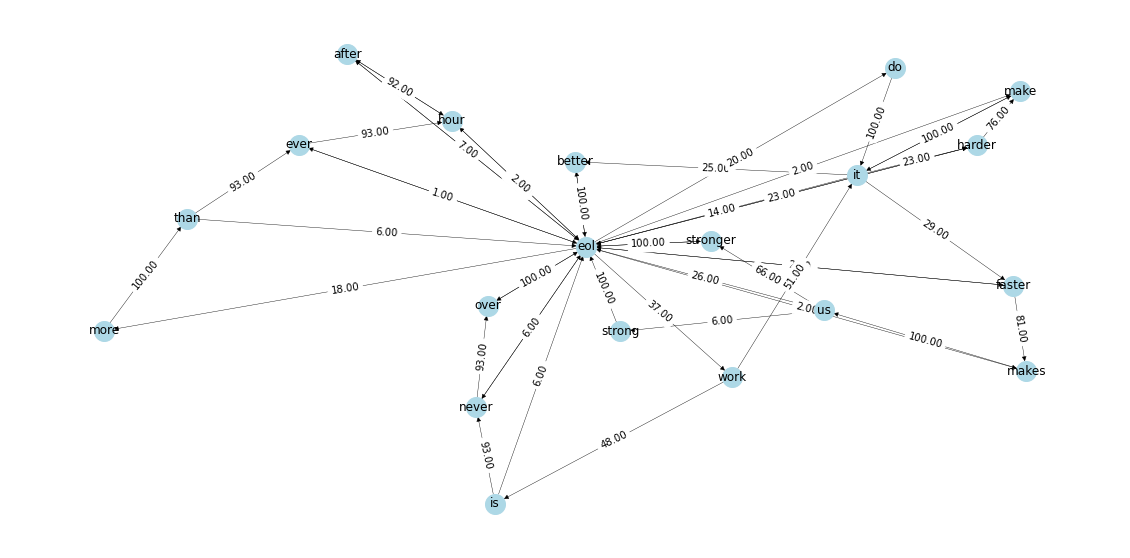

In [23]:
# Copiamos el diccionario de transición.
graph_dict = copy.deepcopy(t_array)

# Modificamos el diccionario anidado para que tenga la estructura que pide Networkx.
for k in uniques:
    for i in graph_dict[k].keys():
        graph_dict[k][i] = {'weight': f'{int(graph_dict[k][i] * 100):.2f}'}

        
# Con el diccionario generamos un Grafo Orientado.
G = nx.from_dict_of_dicts(graph_dict, create_using=nx.DiGraph)
        
# Ploteamos el grafo.
plt.figure(3,figsize=(20,10)) 
labels = nx.get_edge_attributes(G,'weight')
pos = nx.spring_layout(G, k=0.8)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
nx.draw(G, pos , with_labels = True, width=0.4, 
        node_color='lightblue', node_size=400)

### Simulador de caminos
Si simulamos la Cadena asociada al diccionario de transicion, obtenemos un camino que representa una posibilidad nueva de letra.

Configuramos inputs:
- Cantidad de palabras a generar.
- Palabra de inicio.

En este caso, seleccionamos la misma palabra de inicio que la letra original.

In [10]:
# Cantidad de palabras a generar.
n_words = len(words)

# Palabra de inicio.
current = words[0]

Ahora sí, llegamos al generador.

Procedimiento:
- Empezamos con nuestra palabra inicial e ingresamos a un ciclo for.
- Buscamos la palabra actual en nuestra lista de transición y leemos sus sucesores. 
- A continuación, sampleamos de forma aleatoria un valor siguiente con una distribución Piecewise constant. Cada valor tiene la probabilidad de salir que indica el diccionario de transición.
- Guardamos la palabra y volvemos a iniciar el ciclo.

In [11]:
# Creamos nuestra lista de palabras generadas.
gen = [current]

# Iteramos hasta la cantidad de palabras totales indicadas.
for i in range(n_words):

    # Buscamos la palabra en el diccionario de transición. Retenemos sucesores y probabilidades.
    keys_poss = list(t_array[current].keys())
    prob_poss = list(t_array[current].values())
    
    # Con Random Choice, sampleamos un valor. 
    # Cada valor tiene la probabilidad que asigna el diccionario de transición.
    next_w = np.random.choice(keys_poss, 1, p=prob_poss)[0]
    
    # La palabra generada como la palabra actual.
    current = next_w
    
    # Agregamos la palabra generada a la lista.
    gen.append(current)

Se genera como output una lista. La unimos en un solo string y reemplazamos las palabras "eol" por los caracteres correspondientes a nueva línea "\n", para que tenga el formato correcto.

In [12]:
# Unimos la lista generada en un solo string y limpiamos.
new_corpus = ' '.join(gen)
new_corpus = new_corpus.replace('eol', '\n')

¡A continuación, nuestra nueva letra generada por IA!

In [13]:
print(f'{new_corpus}')

work it harder 
 work it better 
 work it make it make it better 
 more than ever hour after hour after hour after hour after 
 work is never over 
 harder make it 
 over 
 harder make it harder make it 
 work is 
 do it better 
 do it faster 
 work is never over 
 do it better 
 never over 
 work it faster makes us stronger 
 do it better 
 make it faster makes us stronger 
 work it faster 
 work it harder make it harder make it better 
 more than ever hour 
 harder make it faster makes us 
 harder make it better 
 stronger 
 more than ever hour after hour after hour after hour after hour after hour 
 work is never over 
 work is never over 
 work is never over 
 work it 
 more than ever hour after 
 do it faster makes us strong 
 more than ever hour 
 work it harder make it harder 
 better 
 do it harder make it faster makes us 
 work it faster 
 work it better 
 work is never over 
 work it faster 
 more than 
 do it better 
 work it better 
 more than ever hour after hour after hou

## Conclusiones

Los modelos generadores de texto de Markov son muy simples y robustos, sin embargo carecen del componente contextual de las palabras; por eso la mayoria de las veces generan secuencias sin sentido.
Por otro lado, el contexto viene dado por el pasado y las Cadenas no retienen información, son procesos sin memoria.

Modelos de secuencia que estudian series de tiempo de texto, son los utilizados por el campo de Natural Language Processing, por ejemplo, en chatbots.